In [1]:
from collections import namedtuple
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import envs

In [2]:
from neural_agent import Agent, Brain
from envs.gridworld import GridworldEnv

In [3]:
def rollout(agent, env, render=False):
    obs, episode_reward, done, step_num = env.reset(),0.0, False, 0
    observations, actions = [], []
    episode_reward = 0.0
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        # Save experience
        observations.append(np.array(obs).reshape(1, -1))
        # Convert to numpy & reshape (8, 8) to (1, 64)
        actions.append(action)
        episode_reward += reward
        obs = next_obs
        step_num += 1
        if render:
            env.render()
    env.close()
    return observations, actions, episode_reward

In [4]:
#Testing the trajectory rollout method
env = GridworldEnv()
# input_shape = (env.observation_space.shape[0] *env.observation_space.shape[1], )
brain = Brain(env.action_space.n)
agent = Agent(env.action_space.n)
obs_batch, actions_batch, episode_reward = rollout(agent,env)

In [5]:
assert len(obs_batch) == len(actions_batch)

In [6]:
# Trajectory: (obs_batch, actions_batch, episode_reward)
# Rollout 100 episodes; Maximum possible steps = 100 *100 = 10e4
trajectories = [rollout(agent, env, render=True) for _ in tqdm(range(100))]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

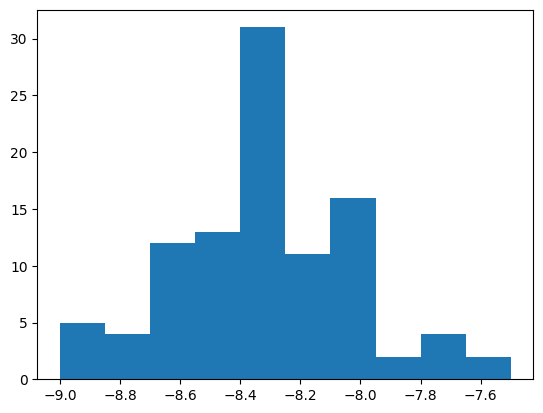

In [7]:
#Visualizing the reward distribution from a sample of experience data
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
sample_ep_rewards = [rollout(agent, env)[-1] for _ in tqdm(range(100))]
plt.hist(sample_ep_rewards, bins=10, histtype="bar");

In [9]:
#create a container for storing trajectories
from collections import namedtuple
Trajectory = namedtuple("Trajectory", ["obs", "actions","reward"])
# Example for understanding the operations:
print(Trajectory(*(1, 2, 3)))
# Explanation: `*` unpacks the tuples into individual
# values
Trajectory(*(1, 2, 3)) == Trajectory(1, 2, 3)
# The rollout(...) function returns a tuple of 3 values:
# (obs, actions, rewards)
# The Trajectory namedtuple can be used to collect
# and store mini batch of experience to train the neuro
# evolution agent
trajectories = [Trajectory(*rollout(agent, env)) for _ in range(2)]

Trajectory(obs=1, actions=2, reward=3)


In [10]:
#Choosing elite experiences for the evolution process
def gather_elite_xp(trajectories, elitism_criterion):
    """Gather elite trajectories from the batch of
        trajectories
    Args:
        batch_trajectories (List): List of episode trajectories containing experiences (obs,actions,episode_reward)
    Returns:
        elite_batch_obs
        elite_batch_actions
        elite_reard_threshold
    """
    batch_obs, batch_actions,batch_rewards = zip(*trajectories)
    reward_threshold = np.percentile(batch_rewards,elitism_criterion)
    indices = [index for index, value in enumerate(batch_rewards) if value >= reward_threshold]
    elite_batch_obs = [batch_obs[i] for i in indices]
    elite_batch_actions = [batch_actions[i] for i in indices]
    unpacked_elite_batch_obs = [item for items in elite_batch_obs for item in items]
    unpacked_elite_batch_actions = [item for items in elite_batch_actions for item in items]
    return np.array(unpacked_elite_batch_obs),np.array(unpacked_elite_batch_actions),reward_threshold

In [11]:
#testing the elite experience gathering routine
elite_obs, elite_actions, reward_threshold = gather_elite_xp(trajectories, elitism_criterion=75)

In [12]:
#implementing a helper method to convert discrete action indices to one-hot encoded vectors or probability distribution over actions
def gen_action_distribution(action_index, action_dim=5):
    action_distribution = np.zeros(action_dim).astype(type(action_index))
    action_distribution[action_index] = 1
    action_distribution = np.expand_dims(action_distribution, 0)
    return action_distribution

In [13]:
#testing the action distribution generation function
elite_action_distributions = np.array([gen_action_distribution(a.item()) for a in elite_actions])

In [14]:
#creating and compile the neural network brain with TensorFlow 2.x using the Keras functional API:
brain = Brain(env.action_space.n)
brain.compile(loss="categorical_crossentropy",optimizer="adam", metrics=["accuracy"])

In [15]:
#testing the brain training loop
elite_obs, elite_action_distributions = elite_obs.astype("float16"), elite_action_distributions.astype("float16")
brain.fit(elite_obs, elite_action_distributions, batch_size=128, epochs=1);

1/1 [==============================] - 0s 287ms/step - loss: 1.4506 - accuracy: 0.0200


In [16]:
class Agent(object):
    def __init__(self, brain):
        """Agent with a neural-network brain powered policy
        Args:
            brain (keras.Model): Neural Network based model
        """
        self.brain = brain
        self.policy = self.policy_mlp
        
    def policy_mlp(self, observations):
        observations = observations.reshape(1, -1)
        action_logits = self.brain.process(observations)
        action = tf.random.categorical(tf.math.log(action_logits), num_samples=1)
        return tf.squeeze(action, axis=1)
    
    def get_action(self, observations):
        return self.policy(observations)

In [17]:
def evaluate(agent, env, render=True):
    obs, episode_reward, done, step_num = env.reset(),0.0, False, 0
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        step_num += 1
        if render:
            env.render()
    return step_num, episode_reward, done, info

In [18]:
env = GridworldEnv()
agent = Agent(brain)
for episode in tqdm(range(10)):
    steps, episode_reward, done, info = evaluate(agent,env)
env.close()

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
#defining parameters fpr the training loop
total_trajectory_rollouts = 70
elitism_criterion = 70 # percentile
num_epochs = 200
mean_rewards = []
elite_reward_thresholds = []

  0%|          | 0/200 [00:00<?, ?it/s]

Episode#:1 elite-reward-threshold: -8.00 reward:-8.29 
Episode#:2 elite-reward-threshold: -8.07 reward:-8.35 
Episode#:3 elite-reward-threshold: -8.20 reward:-8.34 
Episode#:4 elite-reward-threshold: -8.20 reward:-8.32 
Episode#:5 elite-reward-threshold: -8.20 reward:-8.43 
Episode#:6 elite-reward-threshold: -8.20 reward:-8.33 
Episode#:7 elite-reward-threshold: -8.20 reward:-8.35 
Episode#:8 elite-reward-threshold: -8.20 reward:-8.37 
Episode#:9 elite-reward-threshold: -7.97 reward:-8.22 
Episode#:10 elite-reward-threshold: -8.17 reward:-8.40 
Episode#:11 elite-reward-threshold: -8.17 reward:-8.37 
Episode#:12 elite-reward-threshold: -8.20 reward:-8.36 
Episode#:13 elite-reward-threshold: -8.20 reward:-8.35 
Episode#:14 elite-reward-threshold: -8.10 reward:-8.32 
Episode#:15 elite-reward-threshold: -8.10 reward:-8.31 
Episode#:16 elite-reward-threshold: -8.17 reward:-8.38 
Episode#:17 elite-reward-threshold: -8.20 reward:-8.36 
Episode#:18 elite-reward-threshold: -8.27 reward:-8.39 
E

Episode#:147 elite-reward-threshold: -8.20 reward:-8.37 
Episode#:148 elite-reward-threshold: -8.20 reward:-8.39 
Episode#:149 elite-reward-threshold: -8.20 reward:-8.34 
Episode#:150 elite-reward-threshold: -8.10 reward:-8.31 
Episode#:151 elite-reward-threshold: -8.20 reward:-8.36 
Episode#:152 elite-reward-threshold: -8.20 reward:-8.36 
Episode#:153 elite-reward-threshold: -8.20 reward:-8.32 
Episode#:154 elite-reward-threshold: -8.20 reward:-8.37 
Episode#:155 elite-reward-threshold: -8.00 reward:-8.24 
Episode#:156 elite-reward-threshold: -8.10 reward:-8.36 
Episode#:157 elite-reward-threshold: -8.17 reward:-8.37 
Episode#:158 elite-reward-threshold: -8.10 reward:-8.34 
Episode#:159 elite-reward-threshold: -8.10 reward:-8.34 
Episode#:160 elite-reward-threshold: -8.30 reward:-8.48 
Episode#:161 elite-reward-threshold: -8.20 reward:-8.40 
Episode#:162 elite-reward-threshold: -8.20 reward:-8.31 
Episode#:163 elite-reward-threshold: -8.10 reward:-8.37 
Episode#:164 elite-reward-thres

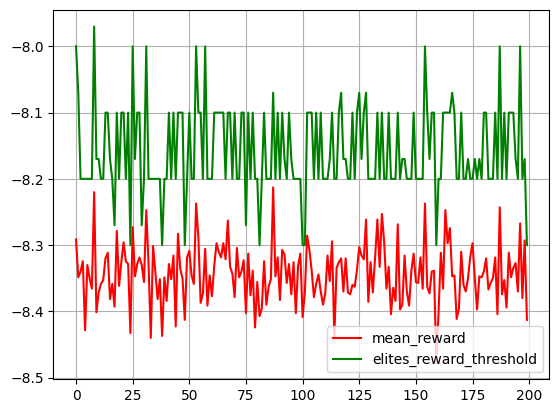

In [20]:
#creating the environment,brain and agent objects
env = GridworldEnv()
input_shape = (env.observation_space.shape[0] *env.observation_space.shape[1], )
brain = Brain(env.action_space.n)
brain.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
agent = Agent(brain)
for i in tqdm(range(num_epochs)):
    trajectories = [Trajectory(*rollout(agent, env)) for _ in range(total_trajectory_rollouts)]
    _, _, batch_rewards = zip(*trajectories)
    elite_obs, elite_actions, elite_threshold = gather_elite_xp(trajectories,elitism_criterion=elitism_criterion)
    elite_action_distributions = np.array([gen_action_distribution(a.item()) for a in elite_actions])
    elite_obs, elite_action_distributions = elite_obs.astype("float16"), elite_action_distributions.astype("float16")
    brain.fit(elite_obs, elite_action_distributions, batch_size=128, epochs=3, verbose=0);
    mean_rewards.append(np.mean(batch_rewards))
    elite_reward_thresholds.append(elite_threshold)
    print(f"Episode#:{i + 1} elite-reward-threshold: {elite_reward_thresholds[-1]:.2f} reward:{mean_rewards[-1]:.2f} ")

plt.plot(mean_rewards, 'r', label="mean_reward")
plt.plot(elite_reward_thresholds, 'g', label="elites_reward_threshold")
plt.legend()
plt.grid()
plt.show()